# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

### Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

### Содержание

1. [Загрузка данных](#load_data)
2. [Разбиение данных на выборки](#split_data)
3. [Исследование моделей](#model_analysis)
4. [Тестирование моделей](#model_testing)
5. [Проверка моделей на адекватность](#adequacy_testing)
6. [Заключение](#conclusion)

<a id="load_data"></a>
## 1. Откройте и изучите файл

Импортируем необходимые библиотеки и загрузим данные. При чтении csv-файла будем использовать автоматическое определение разделителя с помощью движка python.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

In [5]:
behavior_df = pd.read_csv('users_behavior.csv', sep=None, engine='python')
behavior_df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Проверим исходные данные на отсутствие пропусков.

In [6]:
behavior_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Пропусков не обнаружено.

Посмотрим, как распределены данные, в том числе, проверим выбросы.

calls
count    3214.000000
mean       63.038892
std        33.236368
min         0.000000
25%        40.000000
50%        62.000000
75%        82.000000
max       244.000000
Name: calls, dtype: float64
minutes
count    3214.000000
mean      438.208787
std       234.569872
min         0.000000
25%       274.575000
50%       430.600000
75%       571.927500
max      1632.060000
Name: minutes, dtype: float64
messages
count    3214.000000
mean       38.281269
std        36.148326
min         0.000000
25%         9.000000
50%        30.000000
75%        57.000000
max       224.000000
Name: messages, dtype: float64
mb_used
count     3214.000000
mean     17207.673836
std       7570.968246
min          0.000000
25%      12491.902500
50%      16943.235000
75%      21424.700000
max      49745.730000
Name: mb_used, dtype: float64
is_ultra
count    3214.000000
mean        0.306472
std         0.461100
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.

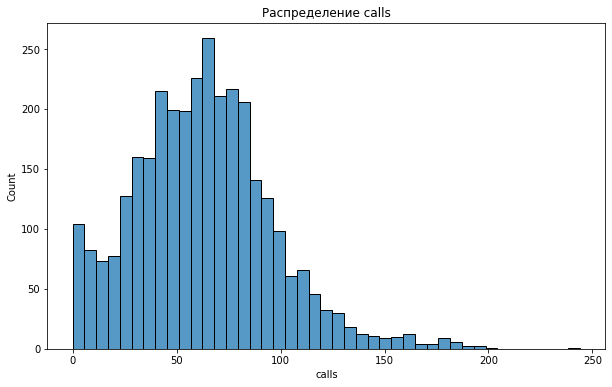

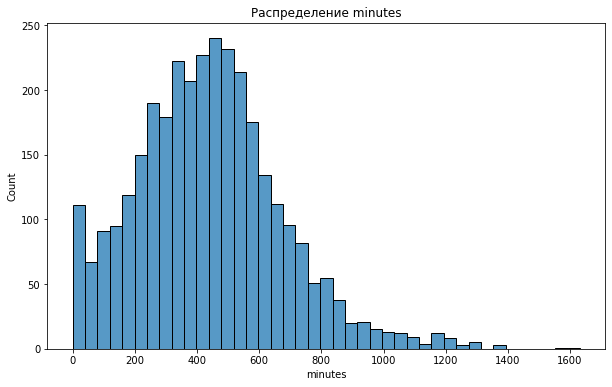

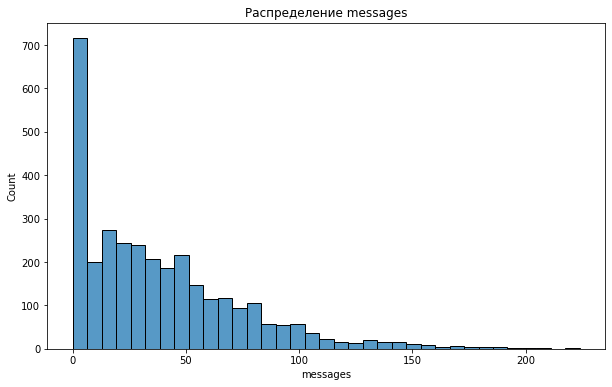

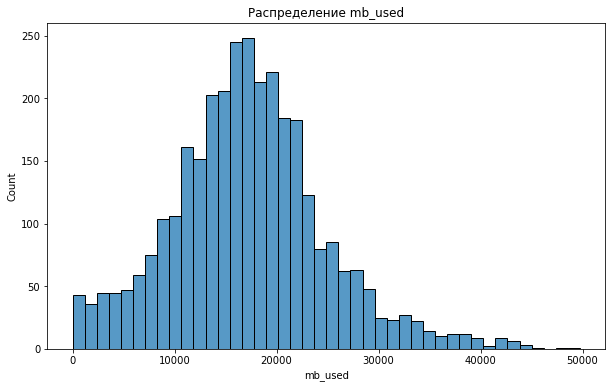

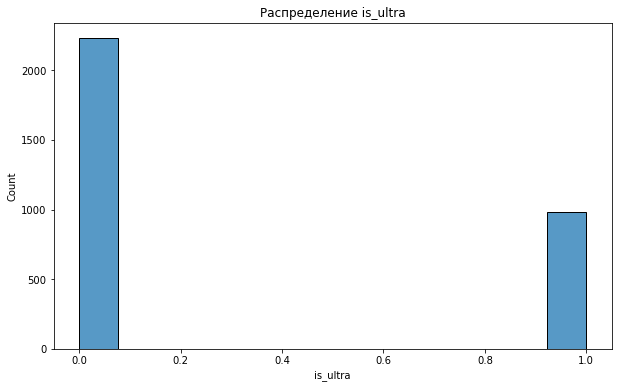

In [7]:
def info(data):
    """
    Функция пробегает по признакам датафрейма и если тип у признака object,
    то выводит уникальные значения и их количество, в противном случае 
    оценивается распределение
    
    """
    for column in data.columns:
        if data[column].dtype == 'object':
            print(column)
            print(data[column].unique())
            print(data[column].value_counts())
            print()
        else:
            print(column)
            print(data[column].describe())
            # Если число уникальных значений в столбце между 1 и длиной столбца, то вывести распределение признака
            if len(data[column].unique()) > 1 and len(data[column].unique()) != len(data[column]):
                plt.figure(figsize=(10, 6))
                sns.histplot(data[column])
                plt.title('Распределение '+ column);
                
info(behavior_df)

Видно, что выбросы многочисленны и неслучайны, так как характеризуют тех пользователей, которые много общаются и/или используют очень много МБ интернета.

Построим матрицы рассеяния и  корреляций для отбора признаков, на основе которых будет происходить обучение и тестирование моделей машинного обучения.

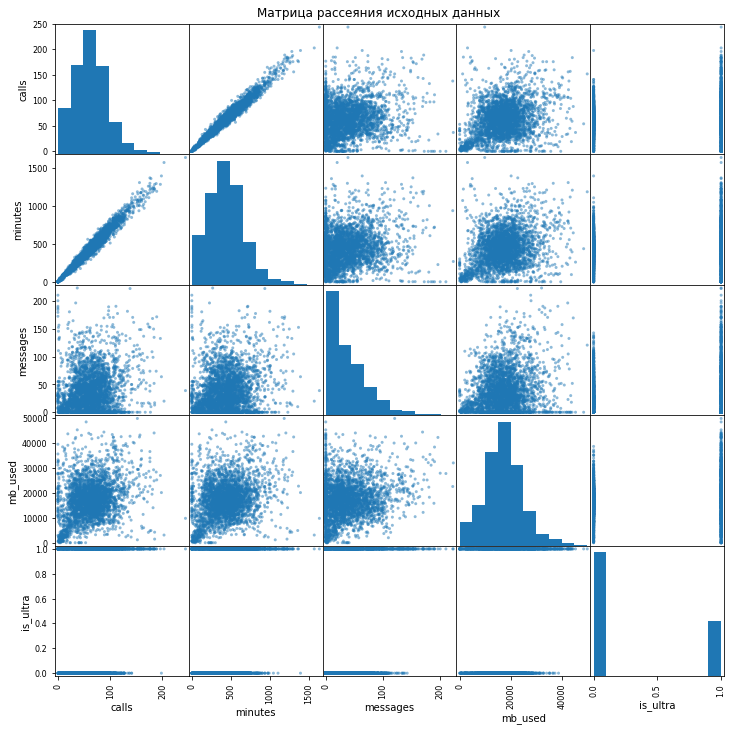

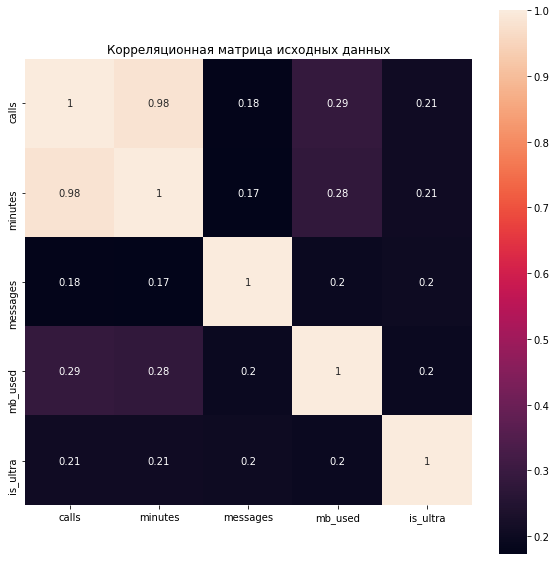

In [8]:
pd.plotting.scatter_matrix(behavior_df, figsize=(12, 12));
plt.suptitle('Матрица рассеяния исходных данных', y=0.9)
plt.show()

corr_matrix = behavior_df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, vmax=1, square=True, annot=True)
plt.title('Корреляционная матрица исходных данных')
plt.show()

Видно, что между минутами и количеством звонков практически линейная зависимость, поэтому отбросим столбец звонков, так как количество минут лучше отражает траты пользователя и, соответственно, текущий тариф (в контексте задачи классификации - вероятный тариф).

In [9]:
dataset = behavior_df.drop(columns=['calls'])
dataset.head()

,minutes,messages,mb_used,is_ultra
0,311.90,83.0,19915.42,0
1,516.75,56.0,22696.96,0
2,467.66,86.0,21060.45,0
3,745.53,81.0,8437.39,1
4,418.74,1.0,14502.75,0


### Вывод

* Исходные данные представляют собой таблицу с 5 столбцами и 3214 строками.
* В данных нет пропущенных значений.
* Выбросы характеризуют поведение небольшой группы пользователей, не являются случайными и единичными, поэтому содержат не менее ценную информацию для машинного обучения, чем основная часть данных.
* По результатам корреляционного анализа решено было удалить столбец "количество звонков", так как он имеет почти линейную зависимость с числом потраченных минут.

<a id="split_data"></a>
## 2. Разбейте данные на выборки

Разделим датасет на зависимые признаки и целевой признак. Далее разобъём полученные множества на обучающее, валидационное и тестовое случайным образом в соотношении 60:20:20.

In [10]:
features = dataset.drop(columns=['is_ultra'])
target = dataset['is_ultra']

x_train_base, x_test, y_train_base, y_test = train_test_split(features, target, test_size=0.2, random_state=17)
x_train, x_validation, y_train, y_validation = train_test_split(x_train_base, y_train_base, test_size=0.25, random_state=17)

In [11]:
x_train.shape, x_validation.shape, x_test.shape, y_train.shape, y_validation.shape, y_test.shape

((1928, 3), (643, 3), (643, 3), (1928,), (643,), (643,))

<a id="model_analysis"></a>
## 3. Исследуйте модели

Для начала посторим бейслайны, то есть модели с параметрами по умолчанию, для того, чтобы можно было сравнить с ними модели с оптимизированными гиперпараметрами.

Первый бейслайн - логистическая регрессия.

In [12]:
log_reg = LogisticRegression(random_state=17)
log_reg.fit(x_train, y_train)

train_score = log_reg.score(x_train, y_train)
test_score = log_reg.score(x_validation, y_validation)

print('Accuracy на обучающей выборке: {:.3f}'.format(train_score))
print('Accuracy на валидационной выборке: {:.3f}'.format(test_score))

Accuracy на обучающей выборке: 0.751
Accuracy на валидационной выборке: 0.726


Результаты не сильно различаются, при этом доля правильных ответов на обучающей выборке всего 0.71, что говорит о недообученности модели. Вероятно, ввиду нелинейной зависимости целевого признака от остальных, мы и получили такую долю правильных ответов. Так как модель недообучилась, то нецелесообразно подбирать параметр регуляризации *C*, а значит, не получится поднять значение метрики модели выше 0.75, поэтому дальше не рассматриваем данную модель.

Второй бейслайн - случайный лес.

In [13]:
rfc = RandomForestClassifier(random_state=17)
rfc.fit(x_train, y_train)

train_score = rfc.score(x_train, y_train)
test_score = rfc.score(x_validation, y_validation)

print('Accuracy на обучающей выборке: {:.3f}'.format(train_score))
print('Accuracy на валидационной выборке: {:.3f}'.format(test_score))

Accuracy на обучающей выборке: 0.999
Accuracy на валидационной выборке: 0.765


Здесь уже на лицо переобучение, так как модель даёт 98% правильных ответов на обучающей выборке и при этом только 75% на валидационной. Потенциально можно поднять качество модели за счёт настройки гиперпараметров.

Третий бейслайн - градиентный бустинг.

In [14]:
gbc = GradientBoostingClassifier(random_state=17)
gbc.fit(x_train, y_train)

train_score = gbc.score(x_train, y_train)
test_score = gbc.score(x_validation, y_validation)

print('Accuracy на обучающей выборке: {:.3f}'.format(train_score))
print('Accuracy на валидационной выборке: {:.3f}'.format(test_score))

Accuracy на обучающей выборке: 0.859
Accuracy на валидационной выборке: 0.784


Градиентный бустинг более устойчив к переобучению, чем случайный лес, что и демонстрируют результаты, при этом доля правильных ответов на валидационной выборке даже лучше, чем у модели "случайный лес".

Проведём настройку гиперпараметров для модели "случайный лес", для большей надёжности в полученных результатах будем использовать кросс-валидацию. Так как количество пользователей тарифов "Смарт" и "Ультра" различается больше чем в два раза, то обучающее множество {x_train_base, y_train_base} будем разбивать на стратифицированные выборки, чтобы обучающие выборки были репрезентативными.

Лучшая доля правильных ответов на обучающей выборке: 0.895
Лучшая доля правильных ответов на валидационной выборке: 0.806

Лучшие параметры модели "случайный лес":
Число деревьев = 30
Максимальная глубина деревьев = 11


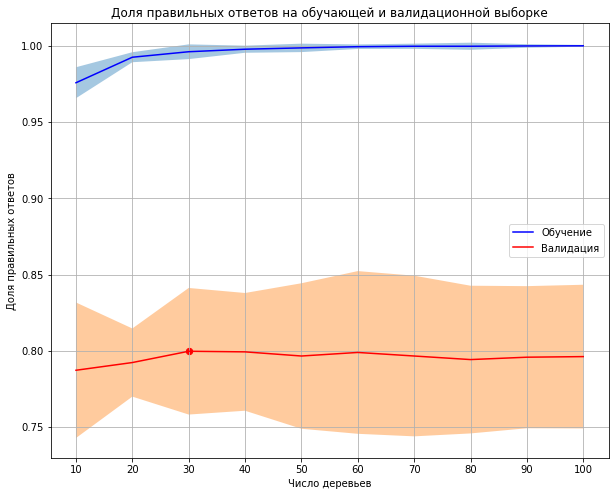

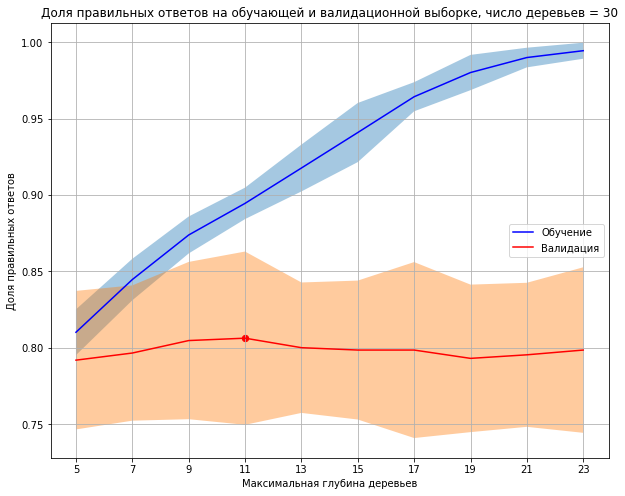

In [15]:
def fill_confidence_interval(x, y, y_std, half_interval=3):
    ci_up_lim = y + half_interval*y_std
    ci_low_lim = y - half_interval*y_std
    plt.fill_between(x, ci_up_lim, ci_low_lim, alpha=0.4)


# Инициализируем страифицированную разбивку нашего датасета для валидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

# Инициализируем классификатор "случайный лес"
rfc = RandomForestClassifier(random_state=17, n_jobs=-1)

# Зададим набор значений числа базовых моделей n_estimators
rng = range(10, 110, 10)
params = {'n_estimators': rng}

# Инициализируем и проведём кросс-валидацию
rfc_grid = GridSearchCV(
    estimator=rfc,
    param_grid=params,
    cv=skf,
    n_jobs=-1,
    return_train_score=True
)
rfc_grid.fit(x_train_base, y_train_base)

# Выведем результаты обучения и тестирования
train_score = rfc_grid.cv_results_['mean_train_score']
train_std = rfc_grid.cv_results_['std_train_score']
test_score = rfc_grid.cv_results_['mean_test_score']
test_std = rfc_grid.cv_results_['std_test_score']
x = rng

plt.figure(figsize=(10, 8))

fill_confidence_interval(x, train_score, train_std)
fill_confidence_interval(x, test_score, test_std)
plt.plot(x, train_score, "b", label='Обучение')
plt.plot(x, test_score, "r", label='Валидация')
plt.scatter(rfc_grid.best_params_['n_estimators'], test_score.max(), c='red', s=40)
plt.legend(loc='center right')
plt.xticks(ticks=x)
plt.xlabel('Число деревьев')
plt.ylabel('Доля правильных ответов')
plt.title('Доля правильных ответов на обучающей и валидационной выборке')
plt.grid(True)

n_estimators_ = rfc_grid.best_params_['n_estimators']

# Повторим эксперимент, зафиксируем число базовых моделей n_estimators
# и зададим значения глубины дерева max_depth
rfc = RandomForestClassifier(n_estimators=n_estimators_, random_state=17, n_jobs=-1)
rng = range(5, 25, 2)
rfc_params = {'max_depth': rng}
rfc_grid = GridSearchCV(rfc, rfc_params, cv=skf, n_jobs=-1, return_train_score=True)
rfc_grid.fit(x_train_base, y_train_base)

# Сохраним лучшую модель
rfc_best = rfc_grid.best_estimator_

# Выведем результаты обучения и валидации
train_score = rfc_grid.cv_results_['mean_train_score']
train_std = rfc_grid.cv_results_['std_train_score']
test_score = rfc_grid.cv_results_['mean_test_score']
test_std = rfc_grid.cv_results_['std_test_score']
x = rng

plt.figure(figsize=(10, 8))

fill_confidence_interval(x, train_score, train_std)
fill_confidence_interval(x, test_score, test_std)
plt.plot(x, train_score, "b", label='Обучение')
plt.plot(x, test_score, "r", label='Валидация')
plt.scatter(rfc_grid.best_params_['max_depth'], test_score.max(), c='red', s=40)
plt.legend(loc='center right')
plt.xticks(ticks=x)
plt.xlabel('Максимальная глубина деревьев')
plt.ylabel('Доля правильных ответов')
ttl = 'Доля правильных ответов на обучающей и валидационной выборке, число деревьев = '+ str(n_estimators_)
plt.title(ttl)
plt.grid(True)

print('Лучшая доля правильных ответов на обучающей выборке: {:.3f}'.format(train_score[test_score == test_score.max()][0]))
print('Лучшая доля правильных ответов на валидационной выборке: {:.3f}'.format(test_score.max()))
print()
print('Лучшие параметры модели "случайный лес":')
print('Число деревьев =', n_estimators_)
print('Максимальная глубина деревьев =', rfc_grid.best_params_['max_depth'])

По полученным в ходе кросс-валидации средним значениям accuracy видно, что за счёт уменьшения максимальной глубины дерева мы уменьшили склонность модели к переобучению, а подобрав число деревьев, мы улучшили качество модели по данной метрике. Также заметно, что дисперсия на валидационных выборках больше, чем на обучающих, что объясняется тем, что размер валидационной выборки меньше обучающей в 4 раза и доля правильных ответов считается от меньшего числа, а значит разница правильных ответов в единицу даст большее различие в доле.

Повторим то же и с градиентным бустингом, только сначала настроим число базовых деревьев, а потом подберём их число.

Лучшая доля правильных ответов на обучающей выборке: 0.826
Лучшая доля правильных ответов на валидационной выборке: 0.808

Лучшие параметры модели "градиентный бустинг":
Число деревьев = 200
Максимальная глубина деревьев = 2


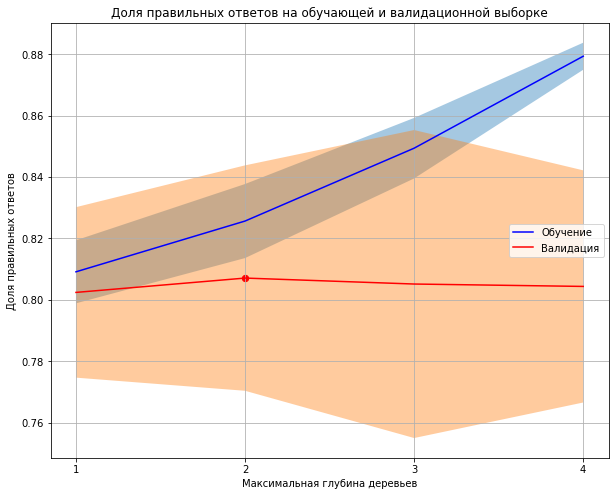

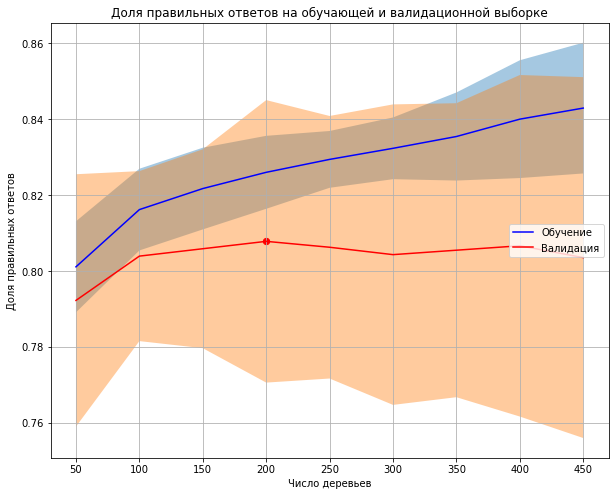

In [16]:
# Инициализируем классификатор "градиентный бустинг"
gbc = GradientBoostingClassifier(random_state=17)

# Зададим набор значений числа базовых моделей n_estimators
rng = range(1, 5)
params = {'max_depth': rng}

# Инициализируем и проведём кросс-валидацию
gbc_grid = GridSearchCV(
    estimator=gbc,
    param_grid=params,
    cv=skf,
    n_jobs=-1,
    return_train_score=True
)
gbc_grid.fit(x_train_base, y_train_base)

# Выведем результаты обучения и тестирования
train_score = gbc_grid.cv_results_['mean_train_score']
train_std = gbc_grid.cv_results_['std_train_score']
test_score = gbc_grid.cv_results_['mean_test_score']
test_std = gbc_grid.cv_results_['std_test_score']
x = rng

plt.figure(figsize=(10, 8))

fill_confidence_interval(x, train_score, train_std)
fill_confidence_interval(x, test_score, test_std)
plt.plot(x, train_score, "b", label='Обучение')
plt.plot(x, test_score, "r", label='Валидация')
plt.scatter(gbc_grid.best_params_['max_depth'], test_score.max(), c='red', s=40)
plt.legend(loc='center right')
plt.xticks(ticks=x)
plt.xlabel('Максимальная глубина деревьев')
plt.ylabel('Доля правильных ответов')
plt.title('Доля правильных ответов на обучающей и валидационной выборке')
plt.grid(True)

max_depth_ = gbc_grid.best_params_['max_depth']

# Повторим эксперимент, зафиксируем глубину дерева max_depth
# и зададим число базовых моделей n_estimators, при этом уменьшим скорость обучения в два раза (0,05)
gbc = GradientBoostingClassifier(learning_rate=0.05, max_depth=max_depth_, random_state=17)
rng = range(50, 500, 50)
params = {'n_estimators': rng}

# Инициализируем и проведём кросс-валидацию
gbc_grid = GridSearchCV(
    estimator=gbc,
    param_grid=params,
    cv=skf,
    n_jobs=-1,
    return_train_score=True
)
gbc_grid.fit(x_train_base, y_train_base)

# Сохраним лучшую модель
gbc_best = gbc_grid.best_estimator_

# Выведем результаты обучения и валидации
train_score = gbc_grid.cv_results_['mean_train_score']
train_std = gbc_grid.cv_results_['std_train_score']
test_score = gbc_grid.cv_results_['mean_test_score']
test_std = gbc_grid.cv_results_['std_test_score']
x = rng

plt.figure(figsize=(10, 8))

fill_confidence_interval(x, train_score, train_std)
fill_confidence_interval(x, test_score, test_std)
plt.plot(x, train_score, "b", label='Обучение')
plt.plot(x, test_score, "r", label='Валидация')
plt.scatter(gbc_grid.best_params_['n_estimators'], test_score.max(), c='red', s=40)
plt.legend(loc='center right')
plt.xticks(ticks=x)
plt.xlabel('Число деревьев')
plt.ylabel('Доля правильных ответов')
plt.title('Доля правильных ответов на обучающей и валидационной выборке')
plt.grid(True)

print('Лучшая доля правильных ответов на обучающей выборке: {:.3f}'.format(train_score[test_score == test_score.max()][0]))
print('Лучшая доля правильных ответов на валидационной выборке: {:.3f}'.format(test_score.max()))
print()
print('Лучшие параметры модели "градиентный бустинг":')
print('Число деревьев =', gbc_grid.best_params_['n_estimators'])
print('Максимальная глубина деревьев =', max_depth_)

Не так сильно, как с моделью "случайный лес", но нам также удалось улучшить качество модели. Обе модели показали примерно одинаковую долю правильных ответов на валидационной выборке, при этом более робастна по результатам кросс-валидации ожидаемо оказалась модель "градиентный бустинг".

### Вывод

* По результатам оценки качества бейслайнов было принято решение обучать модели "случайный лес" и "градиентный бустинг", так как модель "логистическая регрессия" недообучилась и не получится поднять значение метрики *accuracy* выше 0.75.
* Были настроены гиперпараметры моделей "случайный лес" и "градиентный бустинг" с помощью поиска по сетке и 5-кратной кросс-валидации.
* Качество моделей на валидационной выборке оказалось примерно равным (доля правильных ответов 0.811 и 0.810 для "случайного леса" и "градиентного бустинга", соответственно), модель "градиентный бустинг" более устойчива к переобучению, чем "случайный лес".

Лучшие значения гиперпараметров модели "случайный лес":
* Число деревьев = 90
* Максимальная глубина деревьев = 13

Лучшие значения гиперпараметров модели "градиентный бустинг":
* Число деревьев = 200
* Скорость обучения = 0.05
* Максимальная глубина деревьев = 2

<a id="model_testing"></a>
## 4. Проверьте модель на тестовой выборке

Посчитаем долю правильных ответов на тестовой выборке для лучших моделей "случайного леса" и "градиентного бустинга".

In [17]:
rfc_accuracy = rfc_best.score(x_test, y_test)
gbc_accuracy = gbc_best.score(x_test, y_test)

print('Доля правильных ответов модели "случайный лес" на тестовой выборке: {:.3f}'.format(rfc_accuracy))
print('Доля правильных ответов модели "градиентный бустинг" на тестовой выборке: {:.3f}'.format(gbc_accuracy))

Доля правильных ответов модели "случайный лес" на тестовой выборке: 0.809
Доля правильных ответов модели "градиентный бустинг" на тестовой выборке: 0.799


Таким образом, для модели "случайный лес" доля правильных ответов на тестовой выборке составила 81.5%, а для модели "градиентный бустинг" - 79.9%, и по метрике *accuracy* лучше оказалась модель "случайный лес".

<a id="adequacy_testing"></a>
## 5. (бонус) Проверьте модели на адекватность

Построим кривую ошибок ROC (Receiver Operating Characteristic) обеих моделей на тестовой выборке, а также ROC простых моделей классификации для сравнения. Площадь под кривой (AUC ROC) равна доле пар объектов вида (объект класса 1, объект класса 0), которые модель верно упорядочила.

In [18]:
strategy_dict = {
    'Простая со стратификацией': 'stratified',
    'Простая с наиболее частым классом': 'most_frequent',
    'Простая со случайным выбором': 'uniform'
}

dummy_cl_dict = {
    k: DummyClassifier(strategy=v, random_state=17).fit(x_train_base, y_train_base)
    for k, v in strategy_dict.items()
}

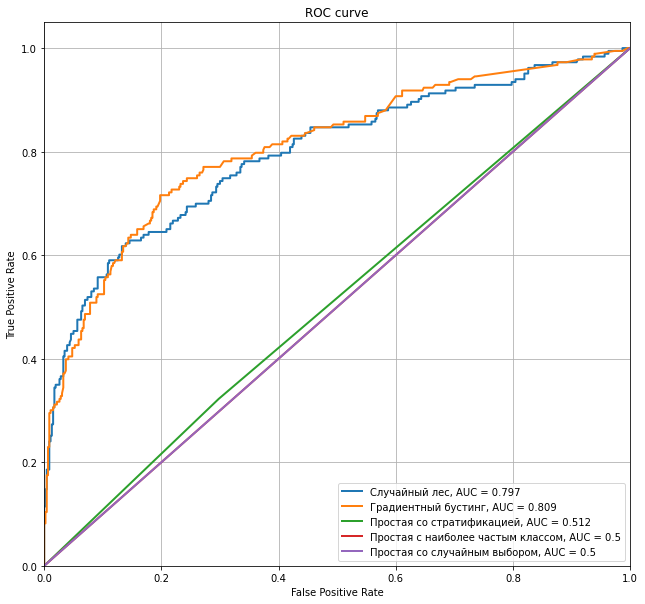

In [19]:
models_dict = {
    'Случайный лес': rfc_best,
    'Градиентный бустинг': gbc_best
}


def plot_roc_for_models_dict(models_dict):
    for desc, model in models_dict.items():
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1], pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=desc + ', AUC = ' + str(np.round(roc_auc, decimals=3)))


plt.figure(figsize=(10.5, 10))

plot_roc_for_models_dict(models_dict)
plot_roc_for_models_dict(dummy_cl_dict)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.grid(True)
plt.show()

Обе полученные модели адекватны, так как *AUC* больше, чем у примитивных моделей классификации, причём модель "градиентный бустинг" по метрике *AUC* даже несколько выигрывает у модели "случайный лес".

<a id="conclusion"></a>
## Заключение

1. В ходе первичного анализа данных были отобраны признаки для обучения и тестирования:
    * minutes — суммарная длительность звонков в минутах,
    * messages — количество sms-сообщений,
    * mb_used — израсходованный интернет-трафик в Мб,
    * is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).
    
    
2. Далее датасет был разделён на обучающее, валидационное и тестовое случайным образом в соотношении 60:20:20 и построены бейслайны моделей "логистическая регрессия", "случайный лес" и "градиентный бустинг".
3. По результатам оценки качества бейслайнов было принято решение обучать модели "случайный лес" и "градиентный бустинг", так как модель "логистическая регрессия" недообучилась и не получится поднять значение метрики *accuracy* выше 0.75.
4. Были настроены гиперпараметры моделей "случайный лес" и "градиентный бустинг" с помощью поиска по сетке и 5-кратной кросс-валидации.
5. Качество моделей на валидационной выборке оказалось примерно равным (доля правильных ответов 0.811 и 0.810 для "случайного леса" и "градиентного бустинга", соответственно), модель "градиентный бустинг" более устойчива к переобучению, чем "случайный лес".

Лучшие значения гиперпараметров модели "случайный лес":
* Число деревьев = 90
* Максимальная глубина деревьев = 13

Лучшие значения гиперпараметров модели "градиентный бустинг":
* Число деревьев = 200
* Скорость обучения = 0.05
* Максимальная глубина деревьев = 2


6. Модели были проверены на тестовой выборке. Для модели "случайный лес" доля правильных ответов на тестовой выборке составила 81.5%, а для модели "градиентный бустинг" - 79.9%, и по метрике accuracy лучше оказалась модель "случайный лес".

7. Обе модели прошли проверку на адекватность.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
